In [1]:
import pandas as pd

In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/deeptriage/gc_20.json"

df = pd.read_json(dataset_path)
df = df[df["owner"].notna()]

In [3]:
df.head(5)

,owner,issue_title,description
0,amit@chromium.org,"Scrolling with some scroll mice (touchpad, etc...",\nProduct Version : <see about:version>\r...
1,jon@chromium.org,Proxy causes some or all network requests to fail,\nProduct Version : 0.2.149.27 (1583)\r\n...
2,pfeldman@chromium.org,"Web inspector button ""dock to main window"" doe...",\nProduct Version : chrome beta 1\r\nURLs...
3,jon@chromium.org,Habari admin interface is not rendered correctly,\nProduct Version : 0.2.149.27 (1583)\r\n...
4,pkasting@chromium.org,Maximize on second larger monitor not working,\nProduct Version : 0.2.149.27\r\nURLs (i...


In [4]:
len(df)

109979

In [3]:
num_cv = 10
sample_threshold=20
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

block = 5
X_df = df[:samples_per_block*block]

Samples per block: 10998


In [4]:
len(X_df)

54990

In [5]:
developers = X_df["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
X_df = X_df[X_df["owner"].isin(filtered_developers)]

In [6]:
num_developers = len(X_df["owner"].unique())
print(f"Total developers: {num_developers}")

Total developers: 629


<Axes: title={'center': 'Number of words in a summary'}, xlabel='issue_title'>

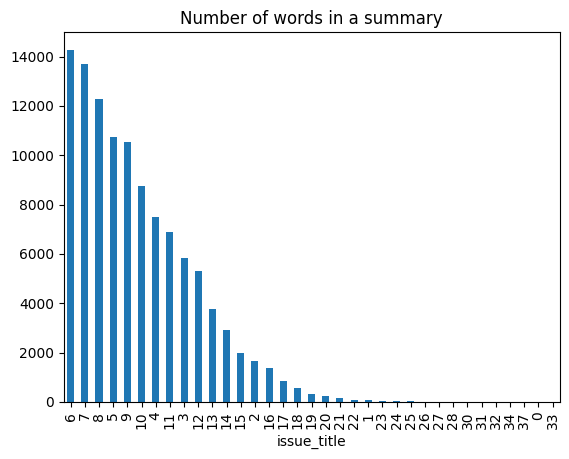

In [7]:
df["issue_title"].apply(lambda x: len(x.split())).value_counts().plot(kind="bar", title="Number of words in a summary")

In [8]:
from transformers import RobertaModel, RobertaTokenizer

In [9]:
model_name = "roberta-base"

encoder = RobertaModel.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
!pip install -U sentence-transformers

In [11]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [12]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [76]:
sentence1 = X_df.iloc[8435].issue_title
sentence2 = X_df.iloc[2101].issue_title
# encode sentences to get their embeddings
embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: "Create google account" link should not be shown when BWSI is disabled
Sentence 2: page_cycler_tests and others deprecated in favor of performance_ui_tests
Similarity score: 0.060293953865766525


In [114]:
X_df.head()

,owner,issue_title,description
0,amit@chromium.org,"Scrolling with some scroll mice (touchpad, etc...",\nProduct Version : <see about:version>\r...
1,jon@chromium.org,Proxy causes some or all network requests to fail,\nProduct Version : 0.2.149.27 (1583)\r\n...
2,pfeldman@chromium.org,"Web inspector button ""dock to main window"" doe...",\nProduct Version : chrome beta 1\r\nURLs...
3,jon@chromium.org,Habari admin interface is not rendered correctly,\nProduct Version : 0.2.149.27 (1583)\r\n...
4,pkasting@chromium.org,Maximize on second larger monitor not working,\nProduct Version : 0.2.149.27\r\nURLs (i...


In [115]:
X_df["text"] = X_df.apply(lambda row: row.issue_title + "\n" + row.description, axis=1)

In [116]:
X_df.head()

,owner,issue_title,description,text
0,amit@chromium.org,"Scrolling with some scroll mice (touchpad, etc...",\nProduct Version : <see about:version>\r...,"Scrolling with some scroll mice (touchpad, etc..."
1,jon@chromium.org,Proxy causes some or all network requests to fail,\nProduct Version : 0.2.149.27 (1583)\r\n...,Proxy causes some or all network requests to f...
2,pfeldman@chromium.org,"Web inspector button ""dock to main window"" doe...",\nProduct Version : chrome beta 1\r\nURLs...,"Web inspector button ""dock to main window"" doe..."
3,jon@chromium.org,Habari admin interface is not rendered correctly,\nProduct Version : 0.2.149.27 (1583)\r\n...,Habari admin interface is not rendered correct...
4,pkasting@chromium.org,Maximize on second larger monitor not working,\nProduct Version : 0.2.149.27\r\nURLs (i...,Maximize on second larger monitor not working\...


In [24]:
all_embeddings = model.encode(X_df.issue_title.to_list(), batch_size=15)

In [25]:
test_df = df[samples_per_block*block: samples_per_block*(block+1)]


In [26]:
test_df = test_df[test_df["owner"].isin(list(X_df["owner"].unique()))]

In [120]:
test_df["text"] = test_df.apply(lambda row: row.issue_title + "\n" + row.description, axis=1)

In [27]:
import torch

In [37]:
test_df[test_df.index == 55070]

,owner,issue_title,description
55102,thestig@chromium.org,Cancelling print preview caused a NOTREACHED i...,\nWhat steps will reproduce the problem?\n1. O...


In [89]:
X_df[X_df.index==11654].issue_title.to_string(index=False)

'Contents not arranged properly under Grid view'

In [90]:
test_df[test_df.index==55074].issue_title.to_string(index=False)

'Upstream changes in net/'

In [29]:
total_matches = 0

for idx, row in test_df.iterrows():
    # print(row.issue_title)
    print(idx)

    test_embed = model.encode(row.issue_title)
    cos = util.cos_sim(test_embed, all_embeddings)
    topk = torch.topk(torch.tensor(cos[0]), k=10)
    print(topk)

    similar = X_df.iloc[topk.indices.numpy()][["issue_title", "owner"]]

    if row.owner in list(similar.owner.unique()):
        # print("Match found")
        # print(row.owner, similar.owner)
        total_matches += 1

    # print(f"Target: {row.owner}")
    # print(f"Found: {similar.owner.to_list()}")
    # print("\n\n")

    # print(X_df.iloc[topk.indices.numpy()][["issue_title", "owner"]])


    # print(row.issue_title, row.owner)

54990
torch.return_types.topk(
values=tensor([0.4696, 0.4537, 0.4519, 0.4480, 0.4423, 0.4419, 0.4392, 0.4363, 0.4360,
        0.4344]),
indices=tensor([45788,  5195, 14256, 13864, 44751, 29598, 30862, 16212, 46586,  7605]))
54992
torch.return_types.topk(
values=tensor([0.7083, 0.6475, 0.6376, 0.6210, 0.6210, 0.6097, 0.6041, 0.6036, 0.6001,
        0.5867]),
indices=tensor([43036,  6573, 25066, 46944, 48976, 11218, 48514, 15868, 45944,  3790]))
54993
torch.return_types.topk(
values=tensor([0.7695, 0.7476, 0.7402, 0.7238, 0.6832, 0.6765, 0.6718, 0.6637, 0.6605,
        0.6602]),
indices=tensor([  945, 25644, 42308, 43789, 42331, 21539, 50643, 40702, 17262,  6175]))
54994


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.6371, 0.5974, 0.5925, 0.5701, 0.5659, 0.5640, 0.5595, 0.5593, 0.5584,
        0.5564]),
indices=tensor([47751, 29570, 38297, 49162, 22029, 19884, 24969,  8978, 42178, 29754]))
54997
torch.return_types.topk(
values=tensor([0.6714, 0.6396, 0.6253, 0.6112, 0.5895, 0.5831, 0.5747, 0.5746, 0.5726,
        0.5676]),
indices=tensor([ 8559, 22504, 18602, 22807, 27065, 17915,  5735, 29691, 20709, 11698]))
54998
torch.return_types.topk(
values=tensor([0.7673, 0.7482, 0.6498, 0.6497, 0.6453, 0.6418, 0.6330, 0.6248, 0.5960,
        0.5945]),
indices=tensor([41697,  7946, 17689, 50888, 23867, 10004, 14099, 50650, 47602,  6892]))
55000
torch.return_types.topk(
values=tensor([0.5599, 0.5443, 0.5399, 0.4671, 0.4619, 0.4603, 0.4514, 0.4464, 0.4458,
        0.4433]),
indices=tensor([ 6747, 21593,  8672, 33222,  4344,   323, 47787, 49578,  6047,   592]))
55002


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.5714, 0.5527, 0.5511, 0.5502, 0.5465, 0.5340, 0.5242, 0.5213, 0.5171,
        0.5104]),
indices=tensor([50189, 42120, 16467, 37379, 42115, 30679, 25326, 25307,   315,  6253]))
55005
torch.return_types.topk(
values=tensor([0.7810, 0.7002, 0.6883, 0.6743, 0.6535, 0.6479, 0.6450, 0.6427, 0.6360,
        0.6239]),
indices=tensor([38745, 30666, 23984, 38694, 50267,  7775, 34256, 23977, 36708, 26910]))
55006
torch.return_types.topk(
values=tensor([0.5741, 0.5606, 0.5505, 0.5336, 0.5230, 0.5067, 0.4934, 0.4887, 0.4851,
        0.4847]),
indices=tensor([48453, 14721, 21926, 10658, 27299, 48575, 48459,  3008, 41322, 35806]))
55007
torch.return_types.topk(
values=tensor([0.7088, 0.6364, 0.6248, 0.6221, 0.6215, 0.6173, 0.6154, 0.6104, 0.6087,
        0.6015]),
indices=tensor([48801, 14201, 35047, 44703, 49381, 27183,  3801, 13584,  6964,  9507]))
55008


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.7970, 0.6942, 0.6823, 0.6803, 0.6796, 0.6623, 0.6610, 0.6467, 0.6459,
        0.6388]),
indices=tensor([46173, 27003, 45777, 43845, 46542, 27565, 50129, 44961, 22941, 41731]))
55009
torch.return_types.topk(
values=tensor([0.5927, 0.5866, 0.5805, 0.5786, 0.5740, 0.5651, 0.5397, 0.5255, 0.5188,
        0.5131]),
indices=tensor([50867, 41762, 42240, 39074, 41736, 36020,   288, 35853, 13657, 50792]))
55010
torch.return_types.topk(
values=tensor([0.6623, 0.5970, 0.5919, 0.5686, 0.5504, 0.5357, 0.5190, 0.5178, 0.5158,
        0.5137]),
indices=tensor([ 1096, 13052, 22154,   819, 32264,  3295, 32266, 32268, 40058, 15464]))
55011
torch.return_types.topk(
values=tensor([0.5883, 0.5358, 0.5304, 0.5188, 0.5082, 0.4867, 0.4837, 0.4821, 0.4806,
        0.4654]),
indices=tensor([14397, 15360, 30044, 15347, 19969, 30417, 39772, 49369, 43165, 43606]))
55012


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.6706, 0.6489, 0.5045, 0.5012, 0.4929, 0.4836, 0.4759, 0.4731, 0.4686,
        0.4612]),
indices=tensor([39995, 17648,  7358, 37623, 11948, 32646, 35557, 10236, 28033, 13882]))
55013
torch.return_types.topk(
values=tensor([0.6704, 0.6056, 0.6047, 0.5967, 0.5684, 0.5675, 0.5510, 0.5476, 0.5464,
        0.5397]),
indices=tensor([26729, 19554,  4933,  1142, 49230,   895, 33463,  8172, 12252, 28942]))
55014
torch.return_types.topk(
values=tensor([0.6511, 0.6209, 0.6061, 0.6013, 0.5732, 0.5592, 0.5586, 0.5532, 0.5524,
        0.5502]),
indices=tensor([36222,  5498, 21532, 13879,  5564, 44288,  7237, 37276, 11995, 15359]))
55015
torch.return_types.topk(
values=tensor([0.7305, 0.6865, 0.6484, 0.6184, 0.6087, 0.5977, 0.5909, 0.5793, 0.5625,
        0.5496]),
indices=tensor([25376, 29204,  8894, 17300, 15633, 37225, 25004, 36850, 24082, 48670]))
55017


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.7407, 0.6893, 0.6424, 0.6324, 0.6234, 0.6213, 0.6163, 0.6130, 0.6124,
        0.5943]),
indices=tensor([29459, 23124, 26796,  7420, 16196,  2020,  8621, 48221, 43671, 27360]))
55019
torch.return_types.topk(
values=tensor([0.6992, 0.6869, 0.6674, 0.6427, 0.6343, 0.6148, 0.6105, 0.6076, 0.6052,
        0.6045]),
indices=tensor([ 3687, 25621, 21680,  1154,  4242, 46619,  2759, 40675, 48116, 33839]))
55020
torch.return_types.topk(
values=tensor([0.4770, 0.4734, 0.4668, 0.4594, 0.4589, 0.4524, 0.4462, 0.4422, 0.4400,
        0.4380]),
indices=tensor([19461, 24209,  3039, 40505, 50807, 22004, 19386, 26869, 40833, 48383]))
55021
torch.return_types.topk(
values=tensor([0.7399, 0.6950, 0.6948, 0.6780, 0.6739, 0.6702, 0.6691, 0.6592, 0.6533,
        0.6526]),
indices=tensor([26344, 36909,  6114, 43870, 26962, 16398, 16538, 25379, 36858, 14937]))
55022


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.7660, 0.7360, 0.6684, 0.6579, 0.6425, 0.6355, 0.6307, 0.6278, 0.6253,
        0.6248]),
indices=tensor([17383, 16896, 31078, 42470, 14631, 30835,  7348, 17010, 10591, 45827]))
55023
torch.return_types.topk(
values=tensor([0.6230, 0.6082, 0.6035, 0.6009, 0.5891, 0.5857, 0.5855, 0.5811, 0.5746,
        0.5741]),
indices=tensor([40454, 10042, 39439, 28834, 34374,  2852, 10898, 38153, 37939, 49762]))
55024
torch.return_types.topk(
values=tensor([0.7267, 0.5584, 0.5583, 0.5481, 0.5466, 0.5432, 0.5431, 0.5374, 0.5209,
        0.5170]),
indices=tensor([29952,  3971, 28424, 12946, 15605, 41775, 14750, 23923, 14739, 37817]))
55025
torch.return_types.topk(
values=tensor([0.7018, 0.6906, 0.6886, 0.6511, 0.6439, 0.6424, 0.6413, 0.6326, 0.6237,
        0.6155]),
indices=tensor([ 2890, 44474,  9581, 35281, 20340, 26820, 27468, 16351, 16378, 39016]))
55027


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.7631, 0.6786, 0.6067, 0.5999, 0.5761, 0.5652, 0.5593, 0.5269, 0.5250,
        0.4974]),
indices=tensor([49412, 50315,  7632, 15734, 35906, 11420, 50192,  2030, 21979, 34428]))
55028
torch.return_types.topk(
values=tensor([0.6996, 0.6604, 0.6311, 0.6267, 0.6016, 0.5610, 0.5502, 0.5489, 0.5391,
        0.5367]),
indices=tensor([10636,   483, 11365, 11367, 42379, 11275, 18127, 11302, 38136,  6064]))
55029
torch.return_types.topk(
values=tensor([0.5895, 0.5772, 0.5767, 0.5661, 0.5584, 0.5564, 0.5509, 0.5470, 0.5443,
        0.5414]),
indices=tensor([35481, 24353, 29341, 46789, 46867, 40624, 49110, 45848, 19402, 21140]))
55030
torch.return_types.topk(
values=tensor([0.6055, 0.4935, 0.4803, 0.4763, 0.4695, 0.4660, 0.4659, 0.4483, 0.4475,
        0.4472]),
indices=tensor([29071, 40140, 45282, 48396, 11345, 21852, 19005,  1111, 10044, 37313]))
55031


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.7641, 0.7566, 0.7294, 0.7234, 0.7218, 0.7161, 0.7118, 0.7111, 0.7092,
        0.7035]),
indices=tensor([26347, 27360, 32238, 11158,  3510, 31192,  3012,  3514, 31204, 38781]))
55033
torch.return_types.topk(
values=tensor([0.4820, 0.4495, 0.3573, 0.3470, 0.3409, 0.3314, 0.3302, 0.3197, 0.3173,
        0.3157]),
indices=tensor([50882, 26789, 28101,  7990, 39245, 12623, 40665, 49991, 42202, 42464]))
55034
torch.return_types.topk(
values=tensor([0.7183, 0.6213, 0.5258, 0.4994, 0.4962, 0.4785, 0.4754, 0.4705, 0.4617,
        0.4577]),
indices=tensor([18164,  2445,  6907, 29424,   257, 15679, 20423, 42212, 20959, 31287]))
55036
torch.return_types.topk(
values=tensor([0.9464, 0.7107, 0.7104, 0.7101, 0.6960, 0.6662, 0.6662, 0.6455, 0.6298,
        0.6219]),
indices=tensor([11832,  6525,  8214,  6920, 21487,  8338,  4986, 38654, 50860,  4954]))
55037


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.6499, 0.5806, 0.5420, 0.5294, 0.5154, 0.5104, 0.4954, 0.4952, 0.4951,
        0.4931]),
indices=tensor([ 8573,  2451, 46145, 46756,   542, 35594, 13164, 13296, 28350, 33359]))
55038
torch.return_types.topk(
values=tensor([0.7079, 0.6845, 0.6327, 0.6293, 0.6005, 0.5900, 0.5892, 0.5846, 0.5803,
        0.5771]),
indices=tensor([ 8694, 22470, 35343, 22592, 15507,  4731,  5537, 12081,  6939,  4179]))
55039
torch.return_types.topk(
values=tensor([0.5840, 0.5840, 0.5503, 0.5416, 0.5203, 0.5134, 0.4994, 0.4972, 0.4787,
        0.4569]),
indices=tensor([ 5689,  4671, 16169, 37910, 39388, 13214, 48812, 40766,  8472, 21738]))
55040
torch.return_types.topk(
values=tensor([0.6719, 0.5886, 0.5797, 0.5711, 0.5529, 0.5516, 0.5405, 0.5244, 0.4995,
        0.4982]),
indices=tensor([47983, 44778, 37330, 46099, 26904,  3014, 44774, 43643, 18380, 46955]))
55042


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.6506, 0.5964, 0.5756, 0.5620, 0.5592, 0.5502, 0.5379, 0.5341, 0.5256,
        0.5193]),
indices=tensor([45005, 22419, 20739, 30437, 22123, 11593, 10093, 21237,   382,  8390]))
55043
torch.return_types.topk(
values=tensor([0.6782, 0.5759, 0.5643, 0.5557, 0.5523, 0.5496, 0.5450, 0.5417, 0.5349,
        0.5327]),
indices=tensor([ 5802, 25473, 50406, 46738, 28540, 16529, 21685, 37216,  2485, 44511]))
55044
torch.return_types.topk(
values=tensor([0.9807, 0.9801, 0.9732, 0.9609, 0.9589, 0.9513, 0.9064, 0.9056, 0.9030,
        0.9029]),
indices=tensor([46420, 49753, 47888, 45501, 43057, 47892, 44227, 49080, 49811, 42028]))
55045
torch.return_types.topk(
values=tensor([0.6489, 0.6161, 0.6114, 0.5712, 0.5712, 0.5689, 0.5623, 0.5352, 0.5217,
        0.5158]),
indices=tensor([44966, 49324, 13335,  6664, 23931, 16748, 48079, 17853, 45686, 38735]))
55047


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.4722, 0.4521, 0.4473, 0.4473, 0.4378, 0.4290, 0.4283, 0.4262, 0.4244,
        0.4233]),
indices=tensor([29129, 50910, 20783, 42169, 35516, 20025, 15361, 22314, 11636, 24781]))
55048
torch.return_types.topk(
values=tensor([0.5106, 0.5051, 0.4812, 0.4769, 0.4721, 0.4659, 0.4608, 0.4579, 0.4523,
        0.4448]),
indices=tensor([46695, 11836, 44449, 48441, 49708, 13196, 46444, 50142, 19954, 49519]))
55050
torch.return_types.topk(
values=tensor([0.6432, 0.5950, 0.5687, 0.5618, 0.5614, 0.5560, 0.5516, 0.5516, 0.5512,
        0.5470]),
indices=tensor([41641, 50129, 31066, 42942, 46385, 21857, 18197,  1442, 27907, 41618]))
55052
torch.return_types.topk(
values=tensor([0.4790, 0.4789, 0.4505, 0.4408, 0.4344, 0.4112, 0.4100, 0.4078, 0.4076,
        0.4055]),
indices=tensor([ 9351, 19494, 43132, 40562, 40146, 46296, 44171, 41440, 44630, 42895]))
55054


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.4161, 0.3918, 0.3836, 0.3777, 0.3585, 0.3509, 0.3497, 0.3496, 0.3492,
        0.3391]),
indices=tensor([27307,  6436, 16630, 46047, 10887, 26937, 18980,  9419, 27558, 31918]))
55056
torch.return_types.topk(
values=tensor([0.6226, 0.5992, 0.5851, 0.5804, 0.5633, 0.5619, 0.5598, 0.5558, 0.5526,
        0.5490]),
indices=tensor([49198, 16603, 48074,  2371, 41151, 37086, 36184,    35, 12449, 33345]))
55057
torch.return_types.topk(
values=tensor([0.5826, 0.5756, 0.5481, 0.5414, 0.5288, 0.5189, 0.5173, 0.5161, 0.5150,
        0.5121]),
indices=tensor([13943,  3930,  7780, 31027,  2776, 38818,  6036, 49822, 42619, 10339]))
55058
torch.return_types.topk(
values=tensor([0.7923, 0.7905, 0.7768, 0.7763, 0.7572, 0.7571, 0.7516, 0.7277, 0.7176,
        0.7154]),
indices=tensor([39212,  1059, 12817, 28551, 31939,  5766,  4080, 33068, 12197, 38482]))
55059


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.6380, 0.5868, 0.5631, 0.5450, 0.5417, 0.5356, 0.5266, 0.5243, 0.5185,
        0.5174]),
indices=tensor([50284, 27388, 49074, 44296, 19581, 39892, 41568,  9584, 34581,   470]))
55062
torch.return_types.topk(
values=tensor([0.5803, 0.5500, 0.5390, 0.5353, 0.5330, 0.5255, 0.5254, 0.4795, 0.4763,
        0.4712]),
indices=tensor([21939, 43882, 25989, 33731, 40345, 23452, 16713, 24290, 16185, 43078]))
55063
torch.return_types.topk(
values=tensor([0.7647, 0.6688, 0.6176, 0.6082, 0.5601, 0.5484, 0.5433, 0.5372, 0.5180,
        0.5154]),
indices=tensor([41544, 46659, 20123, 47308, 43265, 23738, 20122, 37891, 12491, 36206]))
55064
torch.return_types.topk(
values=tensor([0.6116, 0.6101, 0.6043, 0.6026, 0.6007, 0.5983, 0.5953, 0.5862, 0.5835,
        0.5818]),
indices=tensor([49766, 36910,  5768,  9125, 16814, 15468, 12936, 41119, 40545,  3317]))
55065


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.6986, 0.6791, 0.6195, 0.6043, 0.5701, 0.5585, 0.5487, 0.5445, 0.5422,
        0.5422]),
indices=tensor([45631, 39981, 42400, 46975,  3962, 25352, 35016, 30350, 23004, 20649]))
55066
torch.return_types.topk(
values=tensor([0.6472, 0.6404, 0.6196, 0.6133, 0.6123, 0.5881, 0.5873, 0.5854, 0.5854,
        0.5833]),
indices=tensor([41197, 22262, 30093, 39668,  5772,  7948, 22782, 38234, 47823, 39662]))
55067
torch.return_types.topk(
values=tensor([0.5799, 0.5483, 0.5217, 0.5006, 0.4996, 0.4953, 0.4949, 0.4902, 0.4803,
        0.4760]),
indices=tensor([25049, 20002, 32275, 31805, 30282, 31740, 46404,  6207, 45446, 25496]))
55070
torch.return_types.topk(
values=tensor([0.7024, 0.6595, 0.6480, 0.6463, 0.6282, 0.6243, 0.6140, 0.6010, 0.6003,
        0.5942]),
indices=tensor([ 3257, 18772,  5976, 11508,  6368, 35583, 31466,  5122, 11739, 26380]))
55071


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.6653, 0.5872, 0.5832, 0.5810, 0.5785, 0.5771, 0.5721, 0.5631, 0.5604,
        0.5603]),
indices=tensor([38767,  7072, 31156, 29470, 18337, 16539, 11643, 48307, 24011, 47844]))
55072
torch.return_types.topk(
values=tensor([0.6983, 0.6926, 0.6795, 0.6656, 0.6603, 0.6602, 0.6363, 0.6199, 0.6075,
        0.6014]),
indices=tensor([43784, 40382, 42853, 49055, 45654, 36908, 15413, 30498, 39680, 44826]))
55073
torch.return_types.topk(
values=tensor([0.4838, 0.4739, 0.4510, 0.4431, 0.4427, 0.4355, 0.4306, 0.4129, 0.4112,
        0.4110]),
indices=tensor([10398, 17843, 10914,  7506, 43905, 35871, 35301, 28089, 46696,  6819]))
55074
torch.return_types.topk(
values=tensor([0.5764, 0.5471, 0.5274, 0.5164, 0.5149, 0.5149, 0.4910, 0.4862, 0.4823,
        0.4808]),
indices=tensor([ 3850, 50861, 50908, 19538, 35670, 22772,  3847, 46211, 48500, 28148]))
55075


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.9153, 0.7109, 0.6960, 0.6817, 0.6792, 0.6673, 0.6666, 0.6496, 0.6324,
        0.6291]),
indices=tensor([11654, 42070,  7716, 11625,  1808, 32158, 32157, 11640,  8011, 32160]))
55077
torch.return_types.topk(
values=tensor([0.6895, 0.6425, 0.6407, 0.6206, 0.6127, 0.5923, 0.5864, 0.5838, 0.5833,
        0.5691]),
indices=tensor([42312, 42303, 34975,  1010, 26475, 32536, 37943, 21825,  7488, 36648]))
55082
torch.return_types.topk(
values=tensor([0.6834, 0.5529, 0.5526, 0.5300, 0.5123, 0.5031, 0.4981, 0.4976, 0.4972,
        0.4960]),
indices=tensor([34569, 43263,  4496, 35351, 38346, 42353,  3590, 36266, 42730, 25581]))
55083
torch.return_types.topk(
values=tensor([0.8580, 0.8061, 0.7414, 0.7414, 0.7285, 0.7233, 0.7228, 0.7216, 0.7156,
        0.7111]),
indices=tensor([28019, 50267, 30666,  7775, 34256, 12182, 11572, 41206,  5630, 21748]))
55085


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.5456, 0.4424, 0.4154, 0.4146, 0.4040, 0.3986, 0.3967, 0.3960, 0.3945,
        0.3934]),
indices=tensor([36081, 11787, 16748, 28049, 21195, 44487, 19146, 19381,  7277, 46863]))
55087
torch.return_types.topk(
values=tensor([0.6777, 0.6539, 0.6435, 0.6342, 0.6226, 0.6193, 0.6134, 0.6084, 0.6082,
        0.5913]),
indices=tensor([19318, 15933, 20626, 45500,  6499, 24318,  1726, 24880, 44441, 50151]))
55089
torch.return_types.topk(
values=tensor([0.7901, 0.7809, 0.7641, 0.7532, 0.7485, 0.7477, 0.7418, 0.7401, 0.7353,
        0.7347]),
indices=tensor([34753,  1764, 16438, 50396, 26757, 28677, 23981, 46288, 42646, 22570]))
55090
torch.return_types.topk(
values=tensor([0.7680, 0.6298, 0.5865, 0.5753, 0.5685, 0.5659, 0.5481, 0.5416, 0.5297,
        0.5261]),
indices=tensor([32492, 11406, 39333, 35239, 47703, 10934, 43825, 41035, 41038, 10943]))
55092


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.7054, 0.7004, 0.6873, 0.6731, 0.6555, 0.6538, 0.6450, 0.6234, 0.6194,
        0.6054]),
indices=tensor([24571,  2333,  5284, 39056, 28778, 32457,  8448, 39515, 23461,  5067]))
55093
torch.return_types.topk(
values=tensor([0.5264, 0.4882, 0.4833, 0.4814, 0.4667, 0.4640, 0.4613, 0.4509, 0.4490,
        0.4378]),
indices=tensor([34179, 48148, 22568, 41054, 43275, 47760, 36289, 29151, 47546, 38761]))
55094
torch.return_types.topk(
values=tensor([0.5602, 0.5568, 0.5558, 0.5534, 0.5507, 0.5165, 0.4999, 0.4960, 0.4917,
        0.4914]),
indices=tensor([45391, 19371, 50905, 43958, 15817,   237, 19117,  9234,  2834, 28160]))
55095
torch.return_types.topk(
values=tensor([0.6026, 0.5643, 0.5566, 0.5442, 0.5381, 0.5372, 0.5352, 0.5351, 0.5350,
        0.5324]),
indices=tensor([22164, 28781, 32604, 39381, 38417, 49745,  7052, 24091, 40488, 10925]))
55096


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.7322, 0.5785, 0.5384, 0.5365, 0.5140, 0.5105, 0.5056, 0.5009, 0.4985,
        0.4885]),
indices=tensor([40221,  4496, 43352, 24693, 28668,  5797, 50183, 36227,  9883, 13427]))
55097
torch.return_types.topk(
values=tensor([0.7410, 0.6750, 0.6420, 0.6040, 0.5883, 0.5759, 0.5614, 0.5497, 0.5460,
        0.5343]),
indices=tensor([43352,  4496, 40221, 24693, 34569,  5797,  9883, 48920, 47182, 50183]))
55098
torch.return_types.topk(
values=tensor([0.6306, 0.6258, 0.6008, 0.5991, 0.5857, 0.5804, 0.5678, 0.5620, 0.5570,
        0.5499]),
indices=tensor([36458, 39072, 42997, 36446, 47931, 34852, 34278, 30595, 44925,  3676]))
55099
torch.return_types.topk(
values=tensor([0.6000, 0.5486, 0.5447, 0.5376, 0.5130, 0.5069, 0.4983, 0.4861, 0.4823,
        0.4816]),
indices=tensor([49728, 16943, 23647, 22366, 42548, 10079, 49755,  2000,  8358, 15368]))
55100


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.5561, 0.5531, 0.5504, 0.5485, 0.5482, 0.5414, 0.5352, 0.5347, 0.5345,
        0.5296]),
indices=tensor([34489,  6342, 13004, 15336, 16941, 24907, 31628, 15370,  2011, 46282]))
55101
torch.return_types.topk(
values=tensor([0.5337, 0.5218, 0.4986, 0.4968, 0.4865, 0.4732, 0.4721, 0.4590, 0.4540,
        0.4509]),
indices=tensor([30838, 43425, 50203,  3305, 38738, 46746, 18369,  4406, 35237, 20340]))
55102
torch.return_types.topk(
values=tensor([0.6848, 0.6760, 0.6738, 0.6570, 0.6560, 0.6546, 0.6493, 0.6437, 0.6414,
        0.6414]),
indices=tensor([43299, 50650, 38879, 42037, 37471, 40131, 41655, 30503,  4099,  8274]))
55104
torch.return_types.topk(
values=tensor([0.6069, 0.5964, 0.5938, 0.5908, 0.5879, 0.5855, 0.5835, 0.5758, 0.5667,
        0.5633]),
indices=tensor([23560, 37610,  7261,  5921, 23814,  4397, 26112, 21275, 43961, 35376]))
55105


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

torch.return_types.topk(
values=tensor([0.6316, 0.5821, 0.5734, 0.5668, 0.5663, 0.5518, 0.5384, 0.5190, 0.5151,
        0.4994]),
indices=tensor([14983,  9490, 35543, 47991,  3375,  9577, 15408, 15440, 50479, 38517]))
55106
torch.return_types.topk(
values=tensor([0.5039, 0.4870, 0.4820, 0.4796, 0.4757, 0.4593, 0.4399, 0.4215, 0.4181,
        0.4153]),
indices=tensor([ 7928, 42277, 19897, 47983, 42111, 47417, 44152, 45447,  7146, 27495]))
55107
torch.return_types.topk(
values=tensor([0.5889, 0.5627, 0.5543, 0.5516, 0.5492, 0.5353, 0.5226, 0.5159, 0.5149,
        0.5142]),
indices=tensor([ 2729, 31779, 18589, 45756, 31360, 39849, 32465, 10718, 43062, 14795]))
55108


/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)
/tmp/ipykernel_1218752/3773668800.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=10)


KeyboardInterrupt: 

In [33]:
X_df.iloc[5502]

owner                                       jcampan@chromium.org
issue_title                  CRASH: searching on news.google.com
description    \nCRASH: searching on news.google.com\r\n\r\nU...
Name: 5736, dtype: object

In [129]:
total_matches/len(test_df)

0.4392065084141313

In [47]:
0.4711913518332776

/tmp/ipykernel_1140731/2233454408.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk = torch.topk(torch.tensor(cos[0]), k=5)


,issue_title,owner
4786,shill: 3g dongles: don't run dhcpcd on ppp links,quiche@chromium.org
7546,Failed to play mp3 music on the App:Files,mtomasz@chromium.org
8428,Don't show accidental search infobar for bookm...,isherman@chromium.org
9003,webNavigation onCreatedNavigationTarget doesn'...,jochen@chromium.org
31,mp4 files with moof atom dont play,fbarchard@chromium.org


("Don't ship example sound files (1.3MB) installed by alsa-utils",
 'de...@chromium.org')

In [24]:
len(model.encode(sentence1, convert_to_tensor=True))

1024

In [33]:
# tokens = tokenizer(str(sentence1), max_length=50, padding="max_length", truncation=True, return_tensors="pt")
# encodings1 = encoder(input_ids=tokens["input_ids"], attention_mask=tokens["attention_mask"])

# tokens = tokenizer(str(sentence2), max_length=50, padding="max_length", truncation=True, return_tensors="pt")
# encodings2 = encoder(input_ids=tokens["input_ids"], attention_mask=tokens["attention_mask"])

# util.pytorch_cos_sim(encodings1.pooler_output[0].cpu().detach(), encodings2.pooler_output[0].cpu().detach()).item()

0.9977022409439087

In [31]:
encodings1.pooler_output[0].cpu().detach()

tensor([-1.8778e-01,  1.7355e-01,  2.1240e-01,  1.1607e-01, -6.4882e-02,
        -4.1916e-01,  3.1011e-01,  3.2231e-01, -7.3365e-02, -4.8741e-02,
        -1.9027e-01,  9.3727e-02,  8.0243e-02,  1.3210e-01, -1.2497e-01,
        -1.1492e-01,  2.6302e-02,  6.3775e-03, -7.7349e-02, -2.1205e-01,
         2.4901e-01, -2.4632e-02, -5.1050e-02, -9.8065e-02,  4.6330e-01,
         9.7453e-02,  1.3215e-01, -2.7845e-01, -3.4513e-01, -1.7305e-03,
        -2.3607e-02,  3.4116e-01, -2.8000e-02,  2.5268e-02, -1.5155e-01,
        -8.6437e-05, -3.0130e-01,  2.4454e-01, -8.8204e-02, -2.7867e-01,
         1.6598e-01,  2.4728e-01,  1.3855e-01,  1.9302e-02, -1.3854e-01,
         3.9041e-01,  5.8220e-02,  4.8500e-01, -2.9421e-01, -2.2585e-02,
         2.6137e-01,  2.7570e-01, -8.3157e-02,  1.2487e-01, -4.9683e-02,
         6.1158e-01, -1.1188e-01, -3.7462e-01, -9.8203e-02, -2.6143e-01,
         2.6483e-01, -3.5074e-01, -1.2012e-01, -1.0044e-02,  1.3767e-02,
        -2.5773e-01,  1.2054e-01,  2.4969e-01,  1.5

In [32]:
from tqdm import tqdm

In [33]:
X = []
max_tokens = 50

for _, row in tqdm(X_df.iterrows(), total=len(X_df)):
    text = row.issue_title
    tokens = tokenizer(str(text), max_length=max_tokens, padding="max_length", truncation=True, return_tensors="pt")
    encodings = encoder(input_ids=tokens["input_ids"], attention_mask=tokens["attention_mask"])
    pooler_out = encodings.pooler_output.squeeze(0).cpu().detach().numpy()
    
    X.append(pooler_out)

100%|██████████| 7030/7030 [12:55<00:00,  9.07it/s]


In [35]:
X_df["embeddings"] = X

In [40]:
X_df.head()

,owner,issue_title,description,embeddings
0,amit@chromium.org,"Scrolling with some scroll mice (touchpad, etc...",\nProduct Version : <see about:version>\r...,"[0.3622683, 0.014743308, 0.08317446, 0.1922355..."
1,jon@chromium.org,Proxy causes some or all network requests to fail,\nProduct Version : 0.2.149.27 (1583)\r\n...,"[0.37318918, 0.029505463, 0.092881486, 0.20365..."
2,pfeldman@chromium.org,"Web inspector button ""dock to main window"" doe...",\nProduct Version : chrome beta 1\r\nURLs...,"[0.36826685, 0.019743465, 0.07911971, 0.197896..."
3,jon@chromium.org,Habari admin interface is not rendered correctly,\nProduct Version : 0.2.149.27 (1583)\r\n...,"[0.36389366, 0.032136887, 0.108592205, 0.22007..."
4,pkasting@chromium.org,Maximize on second larger monitor not working,\nProduct Version : 0.2.149.27\r\nURLs (i...,"[0.3730424, 0.020901347, 0.094066195, 0.214888..."


In [ ]:
X_df.to_json("dt_gc20_block1_thresh20.json")

In [45]:
!nvidia-smi

Wed Feb  7 22:32:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   36C    P0              36W / 250W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [28]:
from sklearn.cluster import KMeans

In [30]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(all_embeddings)

In [31]:
X_df["cluster"]= kmeans.labels_

In [36]:
cl = X_df[X_df["cluster"] == 4]
len(cl["owner"].unique())

139